# Practice: A Visual Notebook to Using BERT for the First Time

*Credits: first part of this notebook is strongly based on Jay Alammar's [great blog post](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/). His blog is a great way to dive into the DL and NLP concepts.*

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification.png" />

In this notebook, we will use pre-trained deep learning model to process some text. We will then use the output of that model to classify the text. The text is a list of sentences from film reviews. And we will calssify each sentence as either speaking "positively" about its subject of "negatively".

## Models: Sentence Sentiment Classification

Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset

The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library

Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [1]:
%pip install -Uqq transformers

Note: you may need to restart the kernel to use updated packages.


## Part 1. Using BERT for text classification.

## Loading pretrained BERT.

Here we will be using the pretrained DistilBERT model. Here is an example of it:

In [2]:
from transformers import pipeline

model_name = 'distilbert-base-uncased'
unmasker = pipeline('fill-mask', model_name)
unmasker("Hello I'm a [MASK] model.")

[{'sequence': "hello i'm a role model.",
  'score': 0.052928753197193146,
  'token': 2535,
  'token_str': 'role'},
 {'sequence': "hello i'm a fashion model.",
  'score': 0.03968575596809387,
  'token': 4827,
  'token_str': 'fashion'},
 {'sequence': "hello i'm a business model.",
  'score': 0.03474372997879982,
  'token': 2449,
  'token_str': 'business'},
 {'sequence': "hello i'm a model model.",
  'score': 0.03462280333042145,
  'token': 2944,
  'token_str': 'model'},
 {'sequence': "hello i'm a modeling model.",
  'score': 0.018145091831684113,
  'token': 11643,
  'token_str': 'modeling'}]

Here is how we can use the same model to extract features from our text:

In [3]:
import torch

from transformers import logging; logging.set_verbosity_error()  # Ignore warning on model loading.
from transformers import DistilBertModel, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit.'
tokenized_text = tokenizer(text, return_tensors='pt')

with torch.no_grad():
    output = model(**tokenized_text)

output.last_hidden_state.shape

torch.Size([1, 23, 768])

## Loading the dataset

We'll use pandas to read the dataset and load it into a dataframe.

In [4]:
import pandas as pd

dataset_url = 'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv'
dataset = pd.read_csv(dataset_url, delimiter='\t', header=None)
dataset.columns = ['text', 'label']

For performance reasons, we'll only use 2,000 sentences from the dataset

In [5]:
dataset = dataset[:2000]

We can ask pandas how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)

In [6]:
dataset['label'].value_counts()

1    1041
0     959
Name: label, dtype: int64

## Preparing the Dataset

Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

### Tokenization

Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [7]:
tokenized_texts = dataset['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True)).values

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding

After tokenization, `tokenized_texts` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [8]:
max_len = max(len(text) for text in tokenized_texts)
padded_texts = torch.tensor([text + [0] * (max_len - len(text)) for text in tokenized_texts])

Our dataset is now in the `padded_texts` variable, we can view its dimensions below:

In [9]:
padded_texts.shape

torch.Size([2000, 59])

### Masking

If we directly send `padded_texts` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what `attention_mask` is for:

In [10]:
attention_mask = torch.where(padded_texts > 0, 1, 0)
attention_mask.shape

torch.Size([2000, 59])

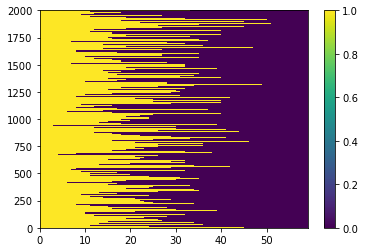

In [11]:
import matplotlib.pyplot as plt

plt.pcolormesh(attention_mask)
plt.colorbar();

## And Now, Deep Learning!

Now that we have our model and inputs ready, let's run our model!

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

In [12]:
with torch.no_grad():
    output = model(padded_texts, attention_mask)

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [13]:
features = output.last_hidden_state[:, 0, :].numpy()
features.shape

(2000, 768)

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [14]:
labels = dataset['label'].values
labels.shape

(2000,)

## Classifier training

Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

In [15]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

## [Extra] Grid Search for Parameters

We can dive into Logistic regression directly with the Scikit Learn default parameters, but sometimes it's worth searching for the best value of the C parameter, which determines regularization strength.

In [16]:
# from sklearn.model_selection import GridSearchCV

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the value of C into the model declaration (e.g. `LogisticRegression(C=5.2)`).

In [17]:
import warnings; warnings.simplefilter('ignore')  # Ignore warning on model fitting.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression().fit(train_features, train_labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-training-logistic-regression.png" />

So how well does our model do in classifying sentences? One way is to check the accuracy against the testing dataset:

In [18]:
lr_clf.score(test_features, test_labels)

0.84

How good is this score? What can we compare it against? Let's first look at a dummy classifier:

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.519 (+/- 0.00)


So our model clearly does better than a dummy classifier. But how does it compare against the best models?

For reference, the [highest accuracy score](http://nlpprogress.com/english/sentiment_analysis.html) for this dataset is currently **96.8**. DistilBERT can be trained to improve its score on this task – a process called **fine-tuning** which updates BERT’s weights to make it achieve a better performance in this sentence classification task (which we can call the downstream task). The fine-tuned DistilBERT turns out to achieve an accuracy score of **90.7**. The full size BERT model achieves **94.9**.

And that’s it! That’s a good first contact with BERT. The next step would be to head over to the documentation and try your hand at [fine-tuning](https://huggingface.co/transformers/examples.html#glue). You can also go back and switch from distilBERT to BERT and see how that works.

## Part 2: Looking back.

__Now it is your turn to reproduce the steps above.__

We shall revisit the first homework and see whether we could improve the results a little bit more. The average ROC-AUC on test set was around $0.9$ (using the words embeddings). 

__Let's see whether we can beat it.__

In [20]:
import os; os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # Ignore warning on wget.

!wget -q -nc https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv
dataset = pd.read_csv('comments.tsv', sep='\t')
dataset[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


Let's prepare data for our BERT model.

In [21]:
tokenized_texts = dataset['comment_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)).values

max_len = max(len(text) for text in tokenized_texts)
padded_texts = torch.tensor([text + [0] * (max_len - len(text)) for text in tokenized_texts])

attention_mask = torch.where(padded_texts > 0, 1, 0)

Now move the model to GPU and use it for feature extraction.

In [22]:
gpu_num = 0
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

In [23]:
import numpy as np

model.to(device)
batch_size = 16
features = []
with torch.no_grad():
    for i in range(0, len(padded_texts), batch_size):
        texts_batch = padded_texts[i : i + batch_size].to(device)
        mask_batch = attention_mask[i : i + batch_size].to(device)
        output = model(texts_batch, mask_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)

features = np.concatenate(features, axis=0)
features.shape

(1000, 768)

Now it is time to split our objects into train and test and train our classifier.

In [24]:
target = dataset['should_ban'].values
train_features, test_features, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42)

In [25]:
lr_clf = LogisticRegression(C=0.1)
lr_clf.fit(train_features, y_train)
lr_clf.score(test_features, y_test)

0.862

Let's also plot the ROC curve and calculate the AUC metric.

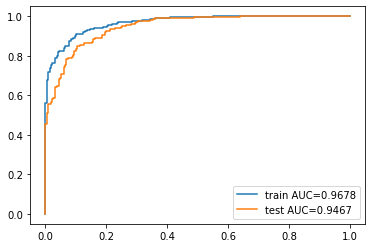

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

proba = lr_clf.predict_proba(train_features)[:, 1]
auc = roc_auc_score(y_train, proba)
plt.plot(*roc_curve(y_train, proba)[:2], label='%s AUC=%.4f' % ('train', auc))

proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(y_test, proba)
plt.plot(*roc_curve(y_test, proba)[:2], label='%s AUC=%.4f' % ('test', auc))

plt.legend();

So, how does it look? Did we achieve better results? 

Here come some further ideas:

* Try using the larger BERT (e.g. BERT-base or BERT-large) and compare the results (be careful, they require more memory).

* Using BERT output for translation? Why not ;)